In [69]:
from scipy.stats import uniform, randint
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]

## Helper Functions

In [89]:
## Function to plot correlation matrix in a heatmap for a group of column starting with a prefix
def plot_correlation_heatmap(df, prefix, with_target=False):
    cols = [col for col in df.columns if col.startswith(prefix)]
    if with_target:
        cols.append("target")
    corr = df[cols].corr()
    plt.figure(figsize=(12, 12))
    sns.heatmap(corr, annot=True, fmt=".2f")
    plt.show()

## Function to sum all a group of columns starting with a prefix
def sum_columns(df, prefix):
    cols = [col for col in df.columns if col.startswith(prefix)]
    return df[cols].sum(axis=1)

## Function to make cross-validation given the model and data and number of splits
def cross_val(model, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=False)
    rmse = []
    r2 = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        rmse.append(np.sqrt(mean_squared_error(y_test, preds)))
        r2.append(r2_score(y_test, preds))
    return np.mean(rmse), np.mean(r2), rmse, r2

def latlon_to_xyz(lat, lon):
    lat, lon = np.radians(lat), np.radians(lon)
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    return x, y, z

# Example: Normalize Cartesian coordinates between 0 and 1
def normalize_xyz(x, y, z):
    # Normalizing each coordinate to the [0, 1] range
    return (x + 1) / 2, (y + 1) / 2, (z + 1) / 2

In [90]:
## Function that group all preprocessing steps

# 3.75, LGBMRegressor
def preprocess_data(df, drop_cols):
    ## Drop columns
    test_df = df.copy()

    ## Create a new feature phi
    test_df["phi"] = test_df["total_individuals"] / test_df["total_households"]
    drop_cols = drop_cols + ["total_individuals", "total_households"]

    ## Create a new feature
    test_df["id_area"] = test_df["total_individuals"] / test_df["AREA_SQKM"]
    test_df["hs_area"] = test_df["total_households"] / test_df["AREA_SQKM"]
    drop_cols = drop_cols + ["AREA_SQKM"]

    ## Normalize some columns
    norm_cols = ["phi", "NL", "id_area", "hs_area"]
    scaler = MinMaxScaler()
    test_df[norm_cols] = scaler.fit_transform(test_df[norm_cols])

    ## Transform lat and lon to xyz
    test_df["x"], test_df["y"], test_df["z"] = zip(*test_df.apply(lambda x: latlon_to_xyz(x["lat"], x["lon"]), axis=1))
    test_df["x"], test_df["y"], test_df["z"] = zip(*test_df.apply(lambda x: normalize_xyz(x["x"], x["y"], x["z"]), axis=1))
    drop_cols = drop_cols + ["lat", "lon"]

    test_df.drop(drop_cols, axis=1, inplace=True)

    return test_df

# def preprocess_data(df, drop_cols):
#     ## Drop columns
#     test_df = df.copy()
#
#     ## Create a new feature phi
#     test_df["phi"] = test_df["total_individuals"] / test_df["total_households"]
#     drop_cols = drop_cols + ["total_individuals", "total_households"]
#
#     ## Normalize some columns
#     norm_cols = ["phi", "NL"]
#     scaler = MinMaxScaler()
#     test_df[norm_cols] = scaler.fit_transform(test_df[norm_cols])
#
#     ## Transform lat and lon to xyz
#     test_df["x"], test_df["y"], test_df["z"] = zip(*test_df.apply(lambda x: latlon_to_xyz(x["lat"], x["lon"]), axis=1))
#     test_df["x"], test_df["y"], test_df["z"] = zip(*test_df.apply(lambda x: normalize_xyz(x["x"], x["y"], x["z"]), axis=1))
#
#     ## Compute distance to the centroid
#     center_lat = test_df["lat"].mean()
#     center_lon = test_df["lon"].mean()
#     test_df["dist_to_center"] = np.sqrt((test_df["lat"] - center_lat) ** 2 + (test_df["lon"] - center_lon) ** 2) # Euclidean distance
#     drop_cols = drop_cols + ["lat", "lon"]
#
#
#     test_df.drop(drop_cols, axis=1, inplace=True)
#
#     return test_df

def run_cv(model, df, target, drop_cols):
    X = df.drop(target, axis=1)
    y = df[target]
    X = preprocess_data(X, drop_cols)

    rmse, r2, rmse_list, r2_list = cross_val(model, X, y)
    # print(f"Model: {model.__class__.__name__} RMSE: {rmse} R2: {r2}")
    # print(f"RMSE list: {rmse_list}")
    # print(f"R2 list: {r2_list}")
    # print("\n\n")

    return rmse, r2

## Data Loading

In [115]:
df = pd.read_csv('outputs/Train.csv')
test_df = pd.read_csv('outputs/Test.csv')
vocab_df = pd.read_csv('variable_descriptions.csv')
admin_df = pd.read_csv('zaf_adminboundaries_tabulardata.csv', sep=";")
df.head()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,...,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,ADM4_PCODE,lat,lon,NL
0,41601001: Ward 1,1674.45058,5888.20750,16.773757,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,...,0.002848,0.007537,0.000000,0.012928,0,0,ZA4161001,-29.682270,24.734743,0.292039
1,41601002: Ward 2,1736.99230,6735.33812,21.496661,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,...,0.014566,0.057127,0.019092,0.004131,0,0,ZA4161002,-29.119311,24.757737,3.207775
2,41601003: Ward 3,2403.57591,7273.04995,10.931425,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,...,0.057560,0.010358,0.001421,0.040881,0,0,ZA4161003,-29.142276,25.094093,0.000000
3,41601004: Ward 4,1740.78737,5734.49046,23.119257,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,...,0.000000,0.000669,0.000000,0.005011,0,0,ZA4161004,-29.372052,24.942867,2.038778
4,41601005: Ward 5,1730.51451,6657.23835,13.652252,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,...,0.004859,0.001290,0.000673,0.017629,0,0,ZA4161005,-29.409381,25.290165,0.000000


In [98]:
admin_df.head()

,ADM4_EN,ADM4_PCODE,ADM4_REF,ADM4ALT1_EN,ADM4ALT2_EN,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,DATE,VALIDON,VALIDTO,ADM1_ID,ADM2_ID,ADM3_ID,AREA_SQKM
0,1,ZA9344001,NaN,NaN,NaN,Makhado,ZA9344,Vhembe,ZA934,Limpopo,ZA9,South Africa,ZA,2018-12-27 00:00:00,2020-11-09 00:00:00,NaN,LIM,DC34,LIM344,"19,00540311"
1,2,ZA9344002,NaN,NaN,NaN,Makhado,ZA9344,Vhembe,ZA934,Limpopo,ZA9,South Africa,ZA,2018-12-27 00:00:00,2020-11-09 00:00:00,NaN,LIM,DC34,LIM344,"10,33772004"
2,3,ZA9344003,NaN,NaN,NaN,Makhado,ZA9344,Vhembe,ZA934,Limpopo,ZA9,South Africa,ZA,2018-12-27 00:00:00,2020-11-09 00:00:00,NaN,LIM,DC34,LIM344,"44,08449178"
3,4,ZA9344004,NaN,NaN,NaN,Makhado,ZA9344,Vhembe,ZA934,Limpopo,ZA9,South Africa,ZA,2018-12-27 00:00:00,2020-11-09 00:00:00,NaN,LIM,DC34,LIM344,"15,26318798"
4,5,ZA9344005,NaN,NaN,NaN,Makhado,ZA9344,Vhembe,ZA934,Limpopo,ZA9,South Africa,ZA,2018-12-27 00:00:00,2020-11-09 00:00:00,NaN,LIM,DC34,LIM344,"106,844335"


In [116]:
admin_df["AREA_SQKM"] = admin_df["AREA_SQKM"].str.replace(",", ".").astype(float)

In [113]:
df["ADM4_PCODE"].head()

0    ZA4161001
1    ZA4161002
2    ZA4161003
3    ZA4161004
4    ZA4161005
Name: ADM4_PCODE, dtype: object

In [114]:
admin_df.head()

,ADM4_PCODE,AREA_SQKM
0,ZA9344001,NaN
1,ZA9344002,NaN
2,ZA9344003,NaN
3,ZA9344004,NaN
4,ZA9344005,NaN


In [117]:
admin_df = admin_df[["ADM4_PCODE", "AREA_SQKM"]]

## Join the admin_df to the main df
df = pd.merge(df, admin_df, on="ADM4_PCODE", how="left")

In [119]:
test_df = pd.merge(test_df, admin_df, on="ADM4_PCODE", how="left")

## Tuning

In [118]:
default_columns = ["ward", "ADM4_PCODE"]
nn_cols = ["dw_00", "psa_00", "lan_00", "pg_00", "pw_00", "stv_00", "car_00", "lln_00"]

columns = [
    default_columns + ["dw_12", "dw_13", "lan_13", "pw_08", "pw_07"],
    default_columns + ["dw_12", "dw_13", "lan_13", "pw_08", "pw_07"] + nn_cols,
    default_columns,
]

models = [
    LinearRegression(),
    LGBMRegressor(n_estimators=100, random_state=42),
    GradientBoostingRegressor(),
    ElasticNet(alpha=0.01, l1_ratio=0.95),
    SVR(),
    AdaBoostRegressor()
]

model_rmse = []
for model in models:
    col_rmse = []
    for cols in columns:
        rmse, r2 = run_cv(model, df, "target", cols)
        col_rmse.append(rmse)

    best_col = np.argmin(col_rmse)
    print(f"Model: {model.__class__.__name__} Best columns: {columns[best_col]} RMSE: {col_rmse[best_col]}")

    model_rmse.append(col_rmse[best_col])

best_model = np.argmin(model_rmse)
print(f"Best model: {models[best_model].__class__.__name__} RMSE: {model_rmse[best_model]}")

Model: LinearRegression Best columns: ['ward', 'ADM4_PCODE', 'dw_12', 'dw_13', 'lan_13', 'pw_08', 'pw_07'] RMSE: 58.425208045164176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14535
[LightGBM] [Info] Number of data points in the train set: 2257, number of used features: 57
[LightGBM] [Info] Start training from score 25.646810
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14535
[LightGBM] [Info] Number of data points in the train set: 2257, number of used features: 57
[LightGBM] [Info] Start training from score 24.692935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

In [120]:
# param_dist = {
#     "n_estimators": randint(50, 200),
#     "max_depth": randint(3, 10),
#     "learning_rate": uniform(0.01, 0.1),
#     "subsample": uniform(0.5, 0.5),
#     "min_child_samples": randint(2, 20),
#     "num_leaves": randint(2, 20),
#     "max_features": ["auto", "sqrt", "log2"]
# }

param_dist = {
    "max_depth": list([2 ** i for i in range(1, 11)]),
    "min_data_in_leaf": list(range(1, 11)),
    "num_leaves": list(range(1, 11)),
}
target = "target"

lgb = LGBMRegressor()
kf = KFold(n_splits=5, shuffle=False)
# rs = GridSearchCV(lgb, param_dist, cv=kf, n_jobs=-1, verbose=1, scoring="neg_mean_squared_error")
rs = RandomizedSearchCV(lgb, param_dist, cv=kf, n_jobs=-1, verbose=1, scoring="neg_mean_squared_error", n_iter=100, random_state=42)
X = df.drop(target, axis=1)
y = df[target]
X = preprocess_data(X, columns[0])
rs.fit(X, y)
best_lgb_params = rs.best_params_
best_lgb_params

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\Public\Documents\Konrad\zindi\women_poverty\venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
55 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Public\Documents\Konrad\zindi\women_poverty\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Public\Documents\Konrad\zindi\women_poverty\venv\Lib\site-packages\lightgbm\sklearn.py", line 1398, in fit
    super().fit(
  File "C:\Users\Public\Documents\Konrad\zindi\women_poverty\venv\Lib\site-packages\lightgbm\sklearn.p

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14535
[LightGBM] [Info] Number of data points in the train set: 2822, number of used features: 57
[LightGBM] [Info] Start training from score 24.507554


{'num_leaves': 9, 'min_data_in_leaf': 8, 'max_depth': 128}

In [121]:
#  {'learning_rate': np.float64(0.07991695162801224),
# 'max_depth': 8,
# 'max_features': 'log2',
# 'min_child_samples': 12,
# 'n_estimators': 156,
# 'num_leaves': 12,
# 'subsample': np.float64(0.7552534636121189)}

best_lgb = LGBMRegressor(**best_lgb_params)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
best_lgb.fit(X_train, y_train)
best_lgb_preds = best_lgb.predict(X_val)
best_lgb_rmse = np.sqrt(mean_squared_error(y_val, best_lgb_preds))
best_lgb_r2 = r2_score(y_val, best_lgb_preds)
best_lgb_rmse, best_lgb_r2

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14535
[LightGBM] [Info] Number of data points in the train set: 2257, number of used features: 57
[LightGBM] [Info] Start training from score 25.005118
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


(np.float64(3.83902797906169), 0.8092259793530059)

In [71]:
best_lgb = LGBMRegressor(**best_lgb_params)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
best_lgb.fit(X_train, y_train)
best_lgb_preds = best_lgb.predict(X_val)
best_lgb_rmse = np.sqrt(mean_squared_error(y_val, best_lgb_preds))
best_lgb_r2 = r2_score(y_val, best_lgb_preds)
best_lgb_rmse, best_lgb_r2

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2257, number of used features: 55
[LightGBM] [Info] Start training from score 25.005118
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


(np.float64(3.9645513600776994), 0.796546682875422)

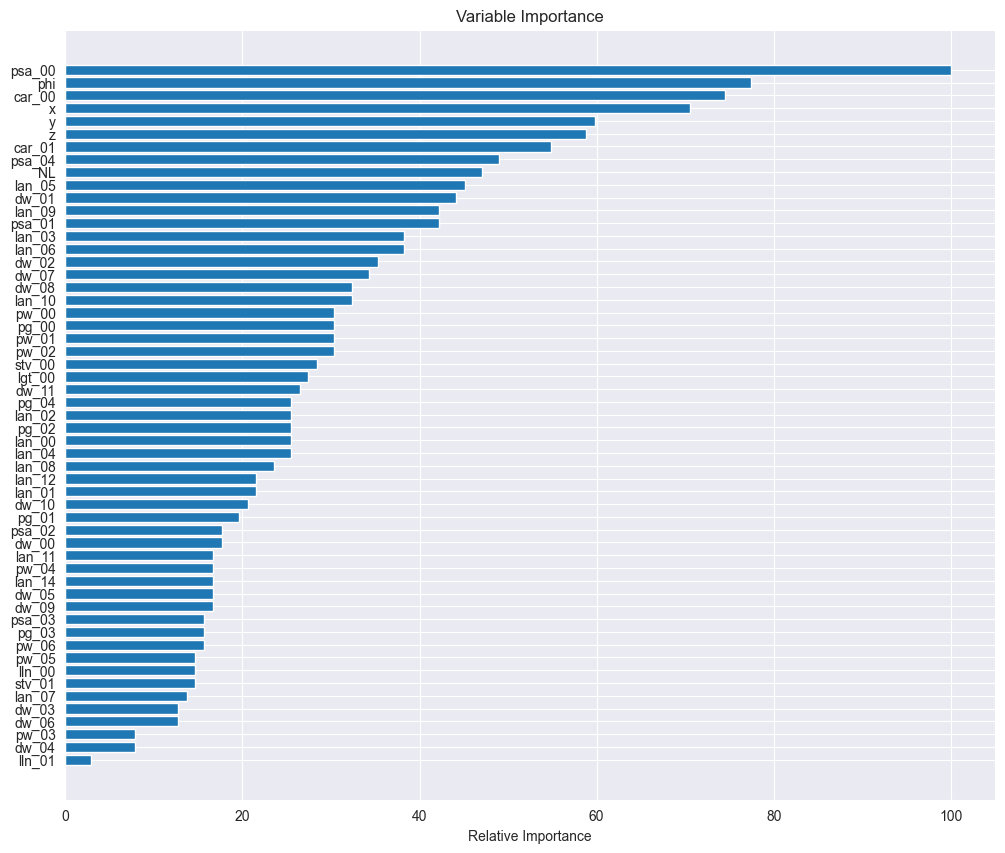

In [53]:
## Feature importance
feature_importance = best_lgb.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [122]:
X = df.drop(target, axis=1)
y = df[target]
X = preprocess_data(X, columns[0])

final_model = LGBMRegressor(**best_lgb_params)
# final_model = LGBMRegressor()
final_model.fit(X, y)

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14535
[LightGBM] [Info] Number of data points in the train set: 2822, number of used features: 57
[LightGBM] [Info] Start training from score 24.507554


LGBMRegressor(max_depth=128, min_data_in_leaf=8, num_leaves=9)

In [124]:
X_test = test_df.copy()
# X_test = X_test.drop([target], axis=1)
X_test = preprocess_data(X_test, columns[0])

test_df['target'] = final_model.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


In [125]:
timestamp = pd.Timestamp.now().strftime("%Y%m%d%H%M%S")

test_df[['ward', 'target']].to_csv(f'{timestamp}_submission.csv', index=False)

## Save model
import joblib
joblib.dump(final_model, f'{timestamp}_model.pkl')

['20250325093610_model.pkl']